In [31]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import time


from sklearn.datasets import load_iris, load_wine, load_breast_cancer
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import davies_bouldin_score, silhouette_score

In [32]:
def get_data(k,std):
    
    if model== "iris":
        data1= load_iris()
    elif model=="wine":
        data1= load_wine()
    else:
        data1=load_breast_cancer()
    
    df=pd.DataFrame(data1['data'],columns=data1['feature_names'])
    
    
    #pca
    pca_1=PCA(n_components=2)
    pca_1.fit(df)
    points=pca_1.transform(df)  
    
    return points

In [33]:
def draw_plot(points,centers,label=True):
    if label==False:
        plt.scatter(points[:,0], points[:,1], s=3)
    else:
        for cluster_id in np.unique(centers):
            cluster_data = points[centers == cluster_id]
            #assigning labels to each cluster to display legends in the scatter plot
            plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {int(cluster_id) + 1}', s=3)
        plt.legend(loc='lower right', fontsize=6) #display the legends on the lower right side of the scatter plot
    plt.xlim(-0.15,1.2)
    plt.ylim(-0.15,1.2)
    plt.show()

In [34]:
def plot_centroids(centers):
    plt.scatter(centers[:,0], centers[:,1], s=3)
    plt.xlim(-0.15,1.2)
    plt.ylim(-0.15,1.2)
    plt.show()

In [35]:
def initialize_centers(points,k):
    np.random.seed(45)
    return points[np.random.randint(points.shape[0],size=k),:]

In [36]:
def get_distance(p1, p2):
    return np.sqrt(np.sum((p1-p2)*(p1-p2)))

In [37]:
def find_nearest_neighbour(points,centroids):
    
    n = len(points)
    k = centroids.shape[0]
    centers = np.zeros(n)
    
    for i in range(n):
        min_dis = 10000
        ind = 0
        for j in range(k):
            
            temp_dis = get_distance(points[i,:],centroids[j,:])
            
            if temp_dis < min_dis:
                min_dis = temp_dis
                ind = j
        centers[i] = ind
    
    return centers

In [38]:
def find_centroids(points,centers):
    n = len(points)
    k = int(np.max(centers))+1
    centroids = np.zeros([k,2])
    
    for i in range(k):
        #print(points[centers==i])
        centroids[i,:] = np.average(points[centers==i])
        
    return centroids

In [9]:
def preprocess(points):
    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(points)
    return normalized_data

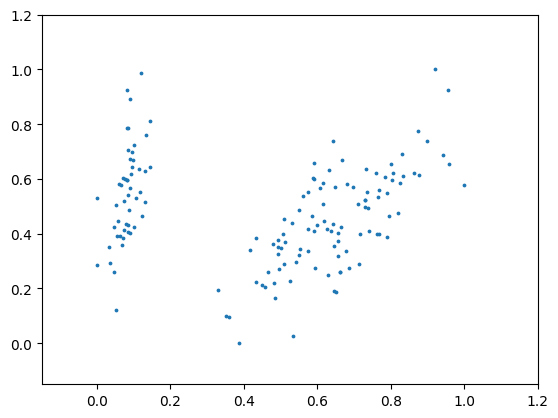

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


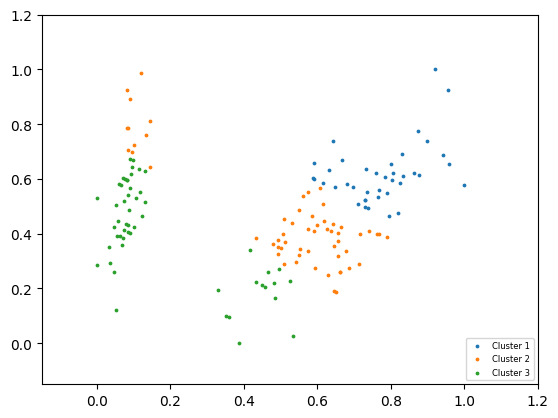

Davies-Bouldin Index: 1.2471972202400476
Silhoutte Score: 0.30076350120687606
Execution time:  0.42175769805908203


In [43]:
k =  3       # Number of centers
model="iris"

points = get_data(k,model)       #dataset
#print(points)

points = preprocess(points)                # Normalize dataset


centroids = initialize_centers(points,k)   # Intialize centroids
plt.figure()                                  
draw_plot(points,centroids,label=False)
#print(centroids)

start_time = time.time()
# run k-means algorithm
for i in range(100):  
    print(i)
    centers = find_nearest_neighbour(points,centroids)       # find nearest centers
    #plt.figure()
    #draw_plot(points,centers)
    centroids = find_centroids(points, centers)               # find centroids

end_time = time.time()

draw_plot(points,centers)

db_index = davies_bouldin_score(points, centers)                   #calculate DB Index
print('Davies-Bouldin Index:', db_index)

silhoutte_score = silhouette_score(points, centers)                #calculate silhoutte score
print('Silhoutte Score:', silhoutte_score)


exec_time = end_time-start_time
print("Execution time: ", exec_time)

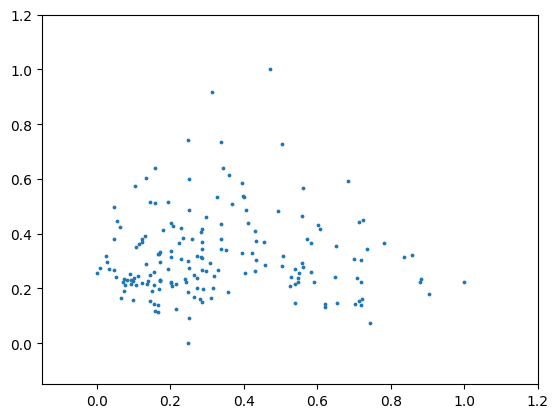

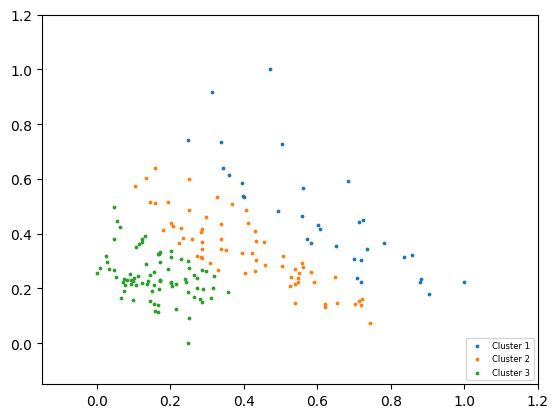

Davies-Bouldin Index: 1.5462170397300332
Silhoutte Score: 0.2992992916043486
Execution time:  1.5237722396850586


In [44]:
n = 100      # number of data points
k = 3        # Number of centers
model = "wine"

points = get_data(k,model)       #dataset

points = preprocess(points)                # Normalize dataset

centroids = initialize_centers(points,k)   # Intialize centroids
plt.figure()                                  
draw_plot(points,centroids,label=False)

start_time = time.time()

# run k-means algorithm
for i in range(300):
    
    centers = find_nearest_neighbour(points,centroids)       # find nearest centers
    #plt.figure()
    #draw_plot(points,centers)
    #plot_centroids(centroids)
    centroids = find_centroids(points,centers) 

end_time = time.time()

draw_plot(points,centers)

db_index = davies_bouldin_score(points, centers)                   #calculate DB Index
print('Davies-Bouldin Index:', db_index)

silhoutte_score = silhouette_score(points, centers)                #calculate silhoutte score
print('Silhoutte Score:', silhoutte_score)

exec_time = end_time-start_time
print("Execution time: ", exec_time)

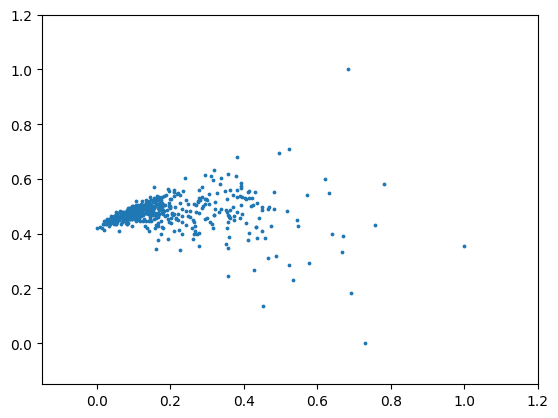

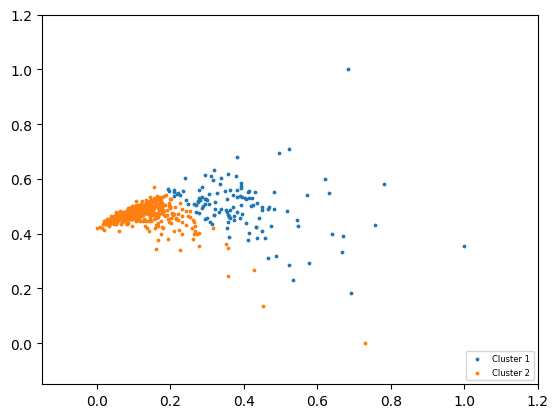

Davies-Bouldin Index: 0.685050028066122
Silhoutte Score: 0.6144602907727351
Execution time:  2.6846516132354736


In [45]:
#n = 100      # number of data points
k = 2        # Number of centers
model = "breast_cancer"

points = get_data(k,model)       #dataset

points = preprocess(points)                # Normalize dataset
#plt.figure()                                  
#draw_plot(points,o_centers,label=False)

centroids = initialize_centers(points,k)   # Intialize centroids
plt.figure()                                  
draw_plot(points,centroids,label=False)

start_time = time.time()

# run k-means algorithm
for i in range(300):
    
    centers = find_nearest_neighbour(points,centroids)       # find nearest centers
    #plt.figure()
    #draw_plot(points,centers)
    #plot_centroids(centroids)
    centroids = find_centroids(points,centers) 

end_time = time.time()

draw_plot(points,centers)

db_index = davies_bouldin_score(points, centers)                   #calculate DB Index
print('Davies-Bouldin Index:', db_index)

silhoutte_score = silhouette_score(points, centers)                #calculate silhoutte score
print('Silhoutte Score:', silhoutte_score)

exec_time = end_time-start_time
print("Execution time: ", exec_time)